In [1]:
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import matplotlib.gridspec as gridspec
import os 
import glob
import re
import nc_time_axis
import time 
import dask.array as da

/tmp/ipykernel_167119/1496084063.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


In [2]:
bound_path = '/nobackup/earfw/cesm2_inputdata//atm/waccm/lb/LBC_1765-2100_1.9x2.5_CCMI_RCP60_za_c130313.nc'
bound_file = xr.open_dataset(bound_path, decode_times=False)
bound_file

<xarray.Dataset>
Dimensions:            (lat: 96, lon: 144, time: 4033)
Coordinates:
  * lat                (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon                (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time               (time) float32 0.0 31.01 58.99 ... 1.226e+05 1.226e+05
Data variables: (12/33)
    date               (time) int32 ...
    CFCL3_LBC          (time, lat) float32 ...
    CF2CL2_LBC         (time, lat) float32 ...
    CFC113_LBC         (time, lat) float32 ...
    CFC114_LBC         (time, lat) float32 ...
    CFC115_LBC         (time, lat) float32 ...
    ...                 ...
    CO2_LBC_mean       (time) float32 ...
    H2_LBC             (time, lat) float32 ...
    TOT_CLOY           (time, lat) float32 ...
    TOT_BROY           (time, lat) float32 ...
    TOT_FOY            (time, lat) float32 ...
    SF6_LBC            (time, lat) float32 ...
Attributes:
    Title:    Time dependent fixed vmr surface boundary conditions
    source:   File created by Doug Kinnison, NCAR,  dkin@ucar,edu
    comment:  NH/SH gradient for CH3Br, HCFC22, HCFC141b, HCFC142b

In [3]:
cli_timesl = bound_file.sel(time=122640.0)
print(cli_timesl['date'].item())

### Mixing Ratios ###

co2_vmr = cli_timesl['CO2_LBC_mean'].item()
print(f'CO2 volume mixing ratio = {co2_vmr}')
ch4_vmr = cli_timesl['CH4_LBC_mean'].item()
print(f'CH4 volume mixing ratio = {ch4_vmr}')
n2o_vmr = cli_timesl['N2O_LBC'].mean(dim='lat').item()
print(f'N2O volume mixing ratio = {n2o_vmr}')

21010101
CO2 volume mixing ratio = 0.0006713724578730762
CH4 volume mixing ratio = 1.6423263105025399e-06
N2O volume mixing ratio = 4.067120755735232e-07


In [4]:
ref_path = '/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-01.nc'
ref_file = xr.open_dataset(ref_path, decode_times=False)
ref_file = ref_file.mean(dim='lat')
ref_file = ref_file.mean(dim='lon')
ref_file = ref_file.sel(
                        # lev=0.0002, 
                        time=31.1, 
                        method='nearest')
ref_file

<xarray.Dataset>
Dimensions:          (mlat: 97, mlon: 80, zlon: 1, nbnd: 2, lev: 126, ilev: 127)
Coordinates:
  * mlat             (mlat) float64 -90.0 -88.12 -86.24 ... 86.24 88.12 90.0
  * mlon             (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * zlon             (zlon) float64 0.0
  * lev              (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev             (ilev) float64 3.551e-10 4.559e-10 ... 985.1 1e+03
    time             float64 31.0
Dimensions without coordinates: nbnd
Data variables: (12/587)
    gw               float64 0.02083
    zlon_bnds        (zlon, nbnd) float64 0.0 357.5
    hyam             (lev) float64 4.055e-13 5.207e-13 ... 0.001261 0.0
    hybm             (lev) float64 0.0 0.0 0.0 0.0 ... 0.9248 0.9693 0.9926
    P0               float64 1e+05
    hyai             (ilev) float64 3.551e-13 4.559e-13 5.854e-13 ... 0.0 0.0
    ...               ...
    WD_HOCL          float32 -4.345e-15
    WI               (lev) float32 0.1399 0.1405 0.1412 ... 0.1764 0.1764 0.1764
    WTHzm            (ilev, zlon) float32 -0.4982 5.349e+03 ... 1.808e+34
    Z3               (lev) float32 5.577e+05 5.446e+05 5.315e+05 ... 631.5 448.3
    e                (lev) float32 0.03052 0.02626 ... 7.156e-23 7.156e-23
    e_SRF            float32 7.156e-23

In [5]:
R = 287
n = ref_file['lev']*100/(R*ref_file['T'])
# n = n.item()
print(n)

<xarray.DataArray (lev: 126)>
array([1.48337659e-13, 1.90502708e-13, 2.44662181e-13, 3.14238022e-13,
       4.03621005e-13, 5.18447448e-13, 6.65961477e-13, 8.55479607e-13,
       1.09897564e-12, 1.41184019e-12, 1.81385998e-12, 2.33048252e-12,
       2.99443851e-12, 3.84784886e-12, 4.94494014e-12, 6.35554879e-12,
       8.16968326e-12, 1.05033782e-11, 1.35064092e-11, 1.73724665e-11,
       2.23527267e-11, 2.87738694e-11, 3.70620789e-11, 4.77752782e-11,
       6.16466682e-11, 7.96441700e-11, 1.03051578e-10, 1.33580626e-10,
       1.73527224e-10, 2.25992054e-10, 2.95193575e-10, 3.86914623e-10,
       5.09145657e-10, 6.73015684e-10, 8.94143628e-10, 1.19458261e-09,
       1.60558191e-09, 2.17150382e-09, 2.95554352e-09, 4.04832483e-09,
       5.58112183e-09, 7.74587545e-09, 1.08257669e-08, 1.52425519e-08,
       2.16235583e-08, 3.08858005e-08, 4.43259906e-08, 6.36774388e-08,
       9.10980374e-08, 1.29046255e-07, 1.79987092e-07, 2.46448877e-07,
       3.31092690e-07, 4.37373147e-07, 5.702173

In [6]:
co2_conc = co2_vmr *n
print(f'CO2 = {co2_conc} molecules per cm3')
ch4_conc = ch4_vmr *n
print(f'CH4 = {ch4_conc} molecules per cm3')
n2o_conc = n2o_vmr *n
print(f'N2O = {n2o_conc} molecules per cm3')

CO2 = <xarray.DataArray (lev: 126)>
array([9.95898187e-17, 1.27898272e-16, 1.64259450e-16, 2.10970753e-16,
       2.70980026e-16, 3.48071338e-16, 4.47108193e-16, 5.74345446e-16,
       7.37821975e-16, 9.47870617e-16, 1.21777564e-15, 1.56462178e-15,
       2.01038354e-15, 2.58333975e-15, 3.31989662e-15, 4.26694041e-15,
       5.48490033e-15, 7.05167887e-15, 9.06783113e-15, 1.16633955e-14,
       1.50070051e-14, 1.93179834e-14, 2.48824590e-14, 3.20750060e-14,
       4.13878752e-14, 5.34709022e-14, 6.91859915e-14, 8.96823531e-14,
       1.16501399e-13, 1.51724841e-13, 1.98184836e-13, 2.59763821e-13,
       3.41826371e-13, 4.51844194e-13, 6.00303406e-13, 8.02009861e-13,
       1.07794347e-12, 1.45788785e-12, 1.98427052e-12, 2.71793379e-12,
       3.74701148e-12, 5.20036744e-12, 7.26812170e-12, 1.02334295e-11,
       1.45174615e-11, 2.07358758e-11, 2.97592493e-11, 4.27512786e-11,
       6.11607133e-11, 8.66381012e-11, 1.20838376e-10, 1.65458988e-10,
       2.22286513e-10, 2.93640285e-10, 3.

In [ ]:
o_concentration = ref_file['O'].item()*n
o = o_concentration
o

In [ ]:
o2_concentration = ref_file['O2'].item()*n
o2 = o2_concentration
o2

In [ ]:
T = ref_file['T'].item()
T

In [ ]:
# # dry air has a density of 1.2041 kg/m3
# kg_cm3 = 1.2041e-6
# # air molar mass = 28.9647 g/mol
# M = 28.9647e-3
# conc = (kg_cm3 / M) * 6.02214e23
# mixing_ratio = conc / ((0.02/8.314*T)*10e-6*6.02214e23)
# m = mixing_ratio

In [ ]:
m = 2e13

In [ ]:
n2 = 0.8*m

In [ ]:
e_concentration = ref_file['EDens'].item()*n
e = e_concentration
e

In [ ]:
o3_concentration = ref_file['O3'].item()*n
o3 = o3_concentration
o3 

In [ ]:
k11 = 7.6e-10* (np.exp(-241/T))       #'Fe+ + O3 --> FeO+ + O2, from Rollason and Plane
k12 = 3.0e-11                         #'FeO+ + O --> Fe+ + O2
k13 = 4.1e-30*((T/300)**-1.52)*m   #'Fe+ + N2 + He, from Rollason and Plane
k14 = 8.3e-30*((T/300)**-1.86)*m    #'Fe+ + O2 + He, from Rollason and Plane
k15 = 5.0e-11                         #'Fe+.N2 or FeO2+ + O --> FeO+ + N2 or O2
k16 = 3.0e-7*((200/T)**0.5)           #'Fe.X+ + e --> Fe + X

In [ ]:
rate = ( (k13*n2 + k14*o2)*k15*o/(k15*o+k16*e) + k11*o3)      *k16*e   /         (k16*e+k12*o)
rate = rate + (k13*n2+k14*o2)*(k16*e/(k15*o+k16*e))  

The e-folding lifetime of Fe+ against neutralization is then 1/rate

In [ ]:
lifetime = 1 / rate
print(lifetime)

In [7]:
o_concentration = ref_file['O']*n
o = o_concentration
o

<xarray.DataArray (lev: 126)>
array([1.39551783e-13, 1.81310165e-13, 2.35031960e-13, 3.04008326e-13,
       3.92503395e-13, 5.05998349e-13, 6.51498307e-13, 8.37948849e-13,
       1.07675411e-12, 1.38243235e-12, 1.77343609e-12, 2.27317898e-12,
       2.91130407e-12, 3.72525917e-12, 4.76223201e-12, 6.08151062e-12,
       7.75737205e-12, 9.88253935e-12, 1.25724430e-11, 1.59704912e-11,
       2.02546711e-11, 2.56457646e-11, 3.24175359e-11, 4.09096459e-11,
       5.15440496e-11, 6.48463010e-11, 8.14730142e-11, 1.02247769e-10,
       1.28208965e-10, 1.60674389e-10, 2.01328487e-10, 2.52340176e-10,
       3.16523528e-10, 3.97554878e-10, 5.00262096e-10, 6.30992738e-10,
       7.98059731e-10, 1.01226796e-09, 1.28759625e-09, 1.64214972e-09,
       2.09954080e-09, 2.69066097e-09, 3.45590235e-09, 4.44785149e-09,
       5.73251104e-09, 7.38581599e-09, 9.48210152e-09, 1.20700498e-08,
       1.51407501e-08, 1.85971050e-08, 2.22133351e-08, 2.56773596e-08,
       2.86586468e-08, 3.08879826e-08, 3.21862969e-08, 3.24511622e-08,
       3.16305085e-08, 2.97198081e-08, 2.67738706e-08, 2.29420267e-08,
       1.84451227e-08, 1.36836074e-08, 9.18361052e-09, 5.45250495e-09,
       2.75647145e-09, 1.16478886e-09, 4.96174920e-10, 2.58230007e-10,
       1.49111471e-10, 9.17199414e-11, 6.55341665e-11, 5.62327857e-11,
       5.41890746e-11, 5.54377656e-11, 5.87288172e-11, 6.34963332e-11,
       6.93839023e-11, 7.59299750e-11, 8.27653840e-11, 8.96995218e-11,
       9.61724461e-11, 1.01157391e-10, 1.03397323e-10, 1.02106286e-10,
       9.70697263e-11, 8.88223489e-11, 7.70778516e-11, 6.23060346e-11,
       4.65049058e-11, 3.16459124e-11, 1.99952831e-11, 1.23795032e-11,
       7.77037823e-12, 5.00429443e-12, 3.30420285e-12, 2.27666393e-12,
       1.60062616e-12, 1.13381069e-12, 7.78886180e-13, 5.20682167e-13,
       3.56782704e-13, 2.45889818e-13, 1.72509441e-13, 1.19578220e-13,
       8.07398697e-14, 5.34263089e-14, 3.48488125e-14, 2.36187983e-14,
       1.63525866e-14, 1.12539577e-14, 7.84088044e-15, 5.38291815e-15,
       3.37396837e-15, 1.89600505e-15, 1.03357112e-15, 6.15218761e-16,
       4.12597816e-16, 2.97864610e-16, 2.19456844e-16, 1.57877480e-16,
       1.10737781e-16, 7.84998250e-17, 6.04056820e-17, 5.21656743e-17,
       4.87479624e-17, 4.91001533e-17])
Coordinates:
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6
    time     float64 31.0

In [8]:
o2_concentration = ref_file['O2']*n
o2 = o2_concentration
o2

<xarray.DataArray (lev: 126)>
array([9.98037054e-19, 1.68054549e-18, 2.81812049e-18, 4.70901830e-18,
       7.84534465e-18, 1.30375975e-17, 2.16185926e-17, 3.57756901e-17,
       5.90916440e-17, 9.74211150e-17, 1.60306653e-16, 2.63256576e-16,
       4.31390367e-16, 7.05245739e-16, 1.14997581e-15, 1.86982908e-15,
       3.03081674e-15, 4.89595442e-15, 7.87978166e-15, 1.26323598e-14,
       2.01682981e-14, 3.20645981e-14, 5.07638889e-14, 8.00405353e-14,
       1.25720158e-13, 1.96799294e-13, 3.07202310e-13, 4.78567946e-13,
       7.44714781e-13, 1.15886787e-12, 1.80543841e-12, 2.81932085e-12,
       4.41760185e-12, 6.95156126e-12, 1.09912394e-11, 1.74607587e-11,
       2.78510912e-11, 4.45518276e-11, 7.13744903e-11, 1.14396860e-10,
       1.83356678e-10, 2.93964527e-10, 4.71767676e-10, 7.58651129e-10,
       1.22345351e-09, 1.97834564e-09, 3.20213180e-09, 5.16850747e-09,
       8.27355698e-09, 1.30490980e-08, 2.01517788e-08, 3.03645048e-08,
       4.45668468e-08, 6.37929016e-08, 8.93210059e-08, 1.22760018e-07,
       1.66151425e-07, 2.22049618e-07, 2.93818168e-07, 3.86331694e-07,
       5.05474798e-07, 6.59407314e-07, 8.58965556e-07, 1.11898800e-06,
       1.45784698e-06, 1.90110764e-06, 2.46934031e-06, 3.18952145e-06,
       4.09805490e-06, 5.23597422e-06, 6.65084821e-06, 8.40298029e-06,
       1.05764928e-05, 1.32850972e-05, 1.66766484e-05, 2.09550773e-05,
       2.63672885e-05, 3.32180633e-05, 4.18515204e-05, 5.26463084e-05,
       6.62116497e-05, 8.34471617e-05, 1.05692092e-04, 1.34085032e-04,
       1.70590223e-04, 2.16350822e-04, 2.78127483e-04, 3.63094409e-04,
       4.73760535e-04, 6.18525885e-04, 8.09214458e-04, 1.05504666e-03,
       1.36402748e-03, 1.75346583e-03, 2.23291873e-03, 2.82036901e-03,
       3.54476808e-03, 4.41725429e-03, 5.48325579e-03, 6.78624498e-03,
       8.32978934e-03, 1.01746471e-02, 1.23671536e-02, 1.49342889e-02,
       1.79686341e-02, 2.15438867e-02, 2.56288657e-02, 3.01232200e-02,
       3.52117457e-02, 4.11935409e-02, 4.80817907e-02, 5.61413404e-02,
       6.55805480e-02, 7.62283950e-02, 8.79649776e-02, 1.00783717e-01,
       1.15024593e-01, 1.31134827e-01, 1.49601571e-01, 1.71112343e-01,
       1.93991850e-01, 2.15743339e-01, 2.34450485e-01, 2.48925027e-01,
       2.58745844e-01, 2.64425394e-01])
Coordinates:
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6
    time     float64 31.0

In [9]:
T = ref_file['T']
T

<xarray.DataArray 'T' (lev: 126)>
array([952.5167 , 952.34985, 952.148  , 951.8887 , 951.57886, 951.23413,
       950.8602 , 950.45105, 950.0029 , 949.5134 , 948.97876, 948.39233,
       947.74634, 947.0286 , 946.2234 , 945.31226, 944.27124, 943.07574,
       941.69293, 940.0725 , 938.1363 , 935.7758 , 932.8545 , 929.2105 ,
       924.65845, 918.98956, 911.97626, 903.37555, 892.9308 , 880.3713 ,
       865.41766, 847.7956 , 827.2521 , 803.57855, 776.6402 , 746.42224,
       713.086  , 676.99805, 638.6814 , 598.71466, 557.6316 , 515.90765,
       473.9772 , 432.24707, 391.23364, 351.70465, 314.6677 , 281.25394,
       252.43457, 228.81581, 210.6511 , 197.53854, 188.80032, 183.51595,
       180.74202, 179.68587, 179.76575, 180.59329, 181.81047, 182.91322,
       183.78575, 184.19707, 184.01141, 183.12573, 181.7518 , 179.91403,
       178.61433, 178.22546, 178.73213, 180.22464, 182.79123, 186.39537,
       190.80876, 195.74677, 200.96759, 206.15057, 211.21198, 216.17046,
       221.27039, 226.8854 , 232.73248, 238.2733 , 242.78499, 247.02539,
       250.67111, 252.84207, 253.73177, 253.0849 , 251.31815, 248.17084,
       243.33852, 238.23714, 234.0465 , 230.09787, 227.22667, 225.10292,
       222.99118, 221.69426, 220.15907, 218.1958 , 216.96028, 215.71088,
       214.45467, 213.53505, 212.33545, 210.8313 , 209.93622, 209.94342,
       210.75659, 211.94035, 213.61757, 215.23277, 216.76178, 219.38126,
       223.64803, 229.64038, 236.71153, 244.26894, 251.9005 , 259.09875,
       265.1843 , 269.55392, 273.06815, 275.7114 , 276.96088, 277.18466],
      dtype=float32)
Coordinates:
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6
    time     float64 31.0

In [ ]:
# # dry air has a density of 1.2041 kg/m3
# kg_cm3 = 1.2041e-6
# # air molar mass = 28.9647 g/mol
# M = 28.9647e-3
# conc = (kg_cm3 / M) * 6.02214e23
# mixing_ratio = conc / ((0.02/8.314*T)*10e-6*6.02214e23)
# m = mixing_ratio

In [10]:
m = 2e13

In [11]:
n2 = 0.8*m

In [12]:
e_concentration = ref_file['EDens']*n
e = e_concentration
e

<xarray.DataArray (lev: 126)>
array([1.19157625e-08, 1.71516643e-08, 2.47692972e-08, 3.57966501e-08,
       5.17120588e-08, 7.46272294e-08, 1.07602538e-07, 1.55101781e-07,
       2.23567121e-07, 3.22270789e-07, 4.64227534e-07, 6.67232149e-07,
       9.55765539e-07, 1.36360789e-06, 1.93662214e-06, 2.73640715e-06,
       3.84464171e-06, 5.36791819e-06, 7.44291697e-06, 1.02416879e-05,
       1.39756791e-05, 1.88942678e-05, 2.52704079e-05, 3.33636685e-05,
       4.33485231e-05, 5.51947588e-05, 6.84950093e-05, 8.22806813e-05,
       9.49691504e-05, 1.04685664e-04, 1.10122802e-04, 1.11652702e-04,
       1.11799731e-04, 1.14347941e-04, 1.22654432e-04, 1.38801045e-04,
       1.64085403e-04, 2.00047261e-04, 2.49002325e-04, 3.14761462e-04,
       4.02086864e-04, 5.18406149e-04, 6.77594685e-04, 9.02351214e-04,
       1.22419140e-03, 1.68542885e-03, 2.34351080e-03, 3.27398049e-03,
       4.54867874e-03, 6.22118585e-03, 8.28399942e-03, 1.06319499e-02,
       1.30304037e-02, 1.51153614e-02, 1.64746435e-02, 1.67737180e-02,
       1.59327732e-02, 1.37516455e-02, 1.19591265e-02, 1.04051136e-02,
       9.39634729e-03, 8.84316643e-03, 8.49128243e-03, 8.22961308e-03,
       7.93497243e-03, 7.75555611e-03, 7.97177354e-03, 8.49421729e-03,
       9.35737391e-03, 1.06933188e-02, 1.24235380e-02, 1.42445944e-02,
       1.59596955e-02, 1.73061140e-02, 1.80596306e-02, 1.77354206e-02,
       9.11760156e-03, 1.08592317e-02, 1.32195471e-02, 9.70151029e-03,
       6.53003614e-03, 3.63247540e-03, 1.82421558e-03, 1.10521684e-03,
       8.97012434e-04, 7.86388621e-04, 7.03325132e-04, 5.98440097e-04,
       4.39874199e-04, 2.60814000e-04, 1.19209166e-04, 3.81586691e-05,
       7.60607440e-06, 1.13741107e-06, 1.46379712e-07, 1.68885639e-08,
       1.84896216e-09, 1.95858616e-10, 2.05045226e-11, 2.15312257e-12,
       2.28743726e-13, 2.53564304e-14, 3.32561726e-15, 8.88882954e-16,
       7.28945291e-16, 9.24806794e-16, 1.26148278e-15, 1.71678178e-15,
       2.32341677e-15, 3.16019624e-15, 4.28441630e-15, 5.81765655e-15,
       7.91491012e-15, 1.06748744e-14, 1.42016190e-14, 1.86253710e-14,
       2.42258317e-14, 3.14301106e-14, 4.08194656e-14, 5.32910876e-14,
       6.83445307e-14, 8.43584945e-14, 9.94678676e-14, 1.12042508e-13,
       1.21048780e-13, 1.26492195e-13])
Coordinates:
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6
    time     float64 31.0

In [13]:
o3_concentration = ref_file['O3']*n
o3 = o3_concentration
o3 

<xarray.DataArray (lev: 126)>
array([2.05643160e-26, 2.66660090e-26, 3.45843585e-26, 4.47850033e-26,
       5.79005176e-26, 7.47624759e-26, 9.64409678e-26, 1.24314072e-25,
       1.60154568e-25, 2.06242581e-25, 2.65510745e-25, 3.41729633e-25,
       4.39743787e-25, 5.65773252e-25, 7.27793262e-25, 9.36007769e-25,
       1.20344122e-24, 1.54665444e-24, 1.98662545e-24, 2.54981753e-24,
       3.26947486e-24, 4.18716147e-24, 5.35458735e-24, 6.83582370e-24,
       8.71009211e-24, 1.10755342e-23, 1.40546158e-23, 1.78025610e-23,
       2.25215865e-23, 2.84869772e-23, 3.60986128e-23, 4.59915875e-23,
       5.92985930e-23, 7.83228809e-23, 1.08386221e-22, 1.63182332e-22,
       2.81494566e-22, 5.83825382e-22, 1.47318561e-21, 4.34289736e-21,
       1.42878350e-20, 5.14587660e-20, 2.02535024e-19, 8.77907125e-19,
       4.17671893e-18, 2.13191183e-17, 1.12184145e-16, 5.76454611e-16,
       2.69926234e-15, 1.07484676e-14, 3.50067202e-14, 9.36262089e-14,
       2.10004309e-13, 4.07735139e-13, 7.08476458e-13, 1.14310832e-12,
       1.77809768e-12, 2.57475509e-12, 3.40158523e-12, 4.18318974e-12,
       4.78671517e-12, 5.08373499e-12, 4.95831185e-12, 4.40083827e-12,
       3.48197129e-12, 2.55773671e-12, 2.03701198e-12, 1.85627840e-12,
       2.12253562e-12, 3.14410558e-12, 5.37815095e-12, 9.42282919e-12,
       1.58037316e-11, 2.48895223e-11, 3.69681687e-11, 5.28469835e-11,
       7.43007075e-11, 1.04236157e-10, 1.47346018e-10, 2.09803131e-10,
       3.02626278e-10, 4.44972419e-10, 6.73959446e-10, 1.03464618e-09,
       1.61363151e-09, 2.54252436e-09, 4.16497753e-09, 7.04890299e-09,
       1.16828232e-08, 1.85619691e-08, 2.78018981e-08, 3.91353336e-08,
       5.17837062e-08, 6.63119012e-08, 8.18926408e-08, 1.00346833e-07,
       1.23222159e-07, 1.48206650e-07, 1.69269228e-07, 1.83428564e-07,
       1.95647590e-07, 2.04489302e-07, 2.16233102e-07, 2.21557704e-07,
       2.17436032e-07, 2.06796654e-07, 1.91766951e-07, 1.75424781e-07,
       1.58332510e-07, 1.43269718e-07, 1.29962181e-07, 1.15702561e-07,
       9.64001031e-08, 7.28440465e-08, 5.30119654e-08, 4.15142728e-08,
       3.62111998e-08, 3.43616654e-08, 3.38329166e-08, 3.35423152e-08,
       3.30226627e-08, 3.27829527e-08, 3.29314532e-08, 3.30914516e-08,
       3.27819039e-08, 3.17977168e-08])
Coordinates:
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6
    time     float64 31.0

In [14]:
k11 = 7.6e-10* (np.exp(-241/T))       #'Fe+ + O3 --> FeO+ + O2, from Rollason and Plane
k12 = 3.0e-11                         #'FeO+ + O --> Fe+ + O2
k13 = 4.1e-30*((T/300)**-1.52)*m   #'Fe+ + N2 + He, from Rollason and Plane
k14 = 8.3e-30*((T/300)**-1.86)*m    #'Fe+ + O2 + He, from Rollason and Plane
k15 = 5.0e-11                         #'Fe+.N2 or FeO2+ + O --> FeO+ + N2 or O2
k16 = 3.0e-7*((200/T)**0.5)           #'Fe.X+ + e --> Fe + X

In [15]:
rate = ( (k13*n2 + k14*o2)*k15*o/(k15*o+k16*e) + k11*o3)      *k16*e   /         (k16*e+k12*o)
rate = rate + (k13*n2+k14*o2)*(k16*e/(k15*o+k16*e))  

The e-folding lifetime of Fe+ against neutralization is then 1/rate

In [16]:
lifetime = 1 / rate
print(lifetime)

<xarray.DataArray (lev: 126)>
array([4412.94206165, 4411.76717761, 4410.34551816, 4408.51946047,
       4406.33888838, 4403.91294592, 4401.28247482, 4398.40373186,
       4395.2521153 , 4391.80971969, 4388.05186293, 4383.93039552,
       4379.39212249, 4374.3522199 , 4368.70003077, 4362.30714076,
       4355.0073324 , 4346.62970671, 4336.94540374, 4325.6066493 ,
       4312.07274959, 4295.59203617, 4275.22510806, 4249.86691149,
       4218.2616355 , 4179.01478465, 4130.63489195, 4071.56799434,
       4000.22892846, 3915.0199892 , 3814.38907842, 3696.95640775,
       3561.65096508, 3407.88468805, 3235.75807043, 3046.33995054,
       2841.95730034, 2626.24218097, 2403.6649011 , 2178.79345464,
       1955.6442376 , 1737.60587886, 1527.54213079, 1327.86702308,
       1141.15574211,  970.58271247,  819.5531209 ,  690.98990504,
        586.28398925,  504.96424144,  445.3061211 ,  403.86165165,
        377.02141823,  361.09883304,  352.83508609,  349.70596352,
        349.94228524,  352.39383

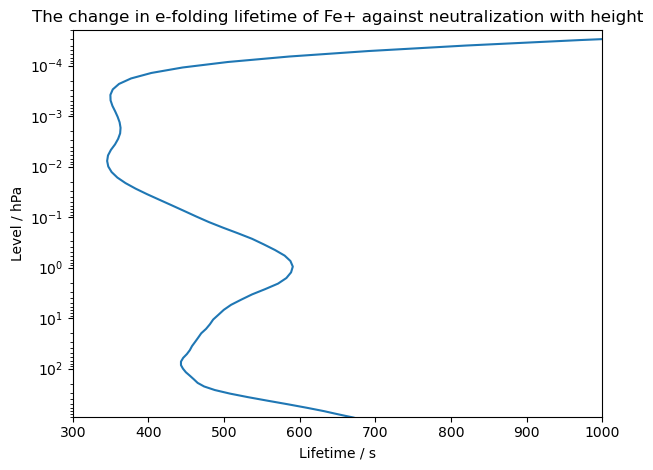

In [41]:
fig, ax = plt.subplots()

ax.plot(lifetime, lifetime.lev)
ax.set_ylabel('Level / hPa')
ax.set_ylim(900, 2e-5)
ax.set_yscale('log')
ax.set_xlabel('Lifetime / s')
ax.set_xlim(300,1000)
ax.set_title('The change in e-folding lifetime of Fe+ against neutralization with height')
plt.tight_layout()
plt.savefig(f'/home/home02/cm21cmr/Sporadic-E-Project/Figures/seasonal_latsl_{var}_{altitude}' , dpi=400, bbox_inches='tight')

plt.show()